In [5]:
from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
from torch.optim import Optimizer
import torch
import sklearn
import numpy as np
import scipy.sparse as sp
from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any
import yaml
from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor
from gad_adversarial_robustness.poison.greedy import multiple_AS
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)

USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET = True
TOP_K = 20

data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()
print(y_binary)

anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
print(anomaly_list)


_, adj, _ = prepare_graph(data)


amount_of_nodes = data.num_nodes

# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges


print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)

tensor([False, False, False,  ..., False, False, False])
[  10   50   70   76  104  124  127  143  151  170  179  181  196  214
  217  224  227  287  289  294  311  333  425  438  451  454  459  539
  565  572  578  581  615  619  641  652  654  660  670  674  692  711
  722  738  781  833  843  869  874  878  882  891  895  915  923  938
  980  982  996 1002 1014 1035 1053 1079 1090 1096 1133 1135 1206 1211
 1224 1229 1235 1287 1293 1310 1362 1391 1414 1426 1533 1540 1543 1547
 1570 1573 1575 1606 1623 1633 1656 1674 1728 1730 1732 1783 1808 1818
 1833 1854 1881 1885 1901 1918 1946 1999 2004 2041 2052 2055 2056 2078
 2089 2121 2126 2198 2215 2234 2263 2265 2294 2307 2336 2340 2375 2382
 2386 2397 2475 2479 2506 2518 2551 2600 2624 2654 2658 2693]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,  

In [6]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')


if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])
sparse_adj = to_torch_sparse_tensor(edge_index)


print("Before poison:")
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False, top_k=TOP_K)

if USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET:
    print("TOP K_AS:")
    print(testingModel.top_k_AS) 
    target_list = np.array(testingModel.top_k_AS)
else:
    target_list = anomaly_list


print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 10

print("Starting attack...")
"""
# -------------
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------
"""
from gad_adversarial_robustness.gad.dominant.dominant_aggr import Dominant as Dominant2
dom_model = Dominant2(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS2, AS_DOM2, AUC_DOM2, ACC_DOM2, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------

Before poison:


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8198161619579315
Top 20 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.039153814315796
Node ID: 1986, Anomaly Score: 2.6422312259674072
Node ID: 1701, Anomaly Score: 2.4811198711395264
Node ID: 306, Anomaly Score: 2.150200366973877
Node ID: 1810, Anomaly Score: 2.123138189315796
Node ID: 1623, Anomaly Score: 2.1134259700775146
Node ID: 2034, Anomaly Score: 2.0106451511383057
Node ID: 1013, Anomaly Score: 1.9478274583816528
Node ID: 1072, Anomaly Score: 1.8760364055633545
Node ID: 88, Anomaly Score: 1.8607043027877808
Node ID: 1914, Anomaly Score: 1.8321725130081177
Node ID: 598, Anomaly Score: 1.7793749570846558
Node ID: 1169, Anomaly Score: 1.7618783712387085
Node ID: 733, Anomaly Score: 1.7481086254119873
Node ID: 1224, Anomaly Score: 1.7205828428268433
Node ID: 109, Anomaly Score: 1.7176262140274048
Node ID: 2045, Anomaly Score: 1.6869860887527466
Node ID: 1725, Anomaly Score: 1.6568459272384644
Node ID: 2155, Anomaly Score: 1.587375

AssertionError: 

In [ ]:
import matplotlib.pyplot as plt

def plot_scores(scores, title='AUC Scores by Budget', xlabel='Budget', ylabel='AUC Score'):
    """
    Plots a list of scores against their corresponding budgets.

    Parameters:
    - scores: List of scores to plot.
    - title: Title of the plot.
    - xlabel: Label for the X-axis.
    - ylabel: Label for the Y-axis.
    """
    budgets = range(1, len(scores) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(budgets, scores, marker='o', linestyle='-', color='b')  # Plotting the scores

    # Adding some flair to the plot
    plt.title(title)  # Title of the plot
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.grid(True)  # Adding a grid for better readability

    # Set integer ticks on the X-axis
    plt.xticks(budgets)  # Set integer ticks

    # Display the plot
    plt.show()


plot_scores(AUC_DOM, "DOMINANT AUC-Score by Budget")
plot_scores(AS_DOM, "Sum of Target Nodes Anomaly Scores by Budget", "Budget", "Anomaly Score")
print(AS_DOM)

: 

In [ ]:
def print_values_not_in_bigger_array(small_array, bigger_array):
    values_not_in_bigger_array = [value for value in small_array if value not in bigger_array]
    if values_not_in_bigger_array:
        print("Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies:", values_not_in_bigger_array)
    else:
        print("All values in the small array are present in the bigger array.")

target_list = np.array(testingModel.top_k_AS)
print_values_not_in_bigger_array(target_list, anomaly_list)

: 

In [7]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')


if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])
sparse_adj = to_torch_sparse_tensor(edge_index)


print("Before poison:")
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False, top_k=TOP_K)

if USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET:
    print("TOP K_AS:")
    print(testingModel.top_k_AS) 
    target_list = np.array(testingModel.top_k_AS)
else:
    target_list = anomaly_list


print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 10

print("Starting attack...")
"""
# -------------
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------
"""

from gad_adversarial_robustness.gad.dominant.dominant_aggr import Dominant as Dominant2
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS2, AS_DOM2, AUC_DOM2, ACC_DOM2, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------

Before poison:


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8246489595669091
Top 20 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.029977321624756
Node ID: 1986, Anomaly Score: 2.6162357330322266
Node ID: 1701, Anomaly Score: 2.345184803009033
Node ID: 306, Anomaly Score: 2.203840970993042
Node ID: 1623, Anomaly Score: 2.139416217803955
Node ID: 1810, Anomaly Score: 2.1330208778381348
Node ID: 2034, Anomaly Score: 2.0579686164855957
Node ID: 1013, Anomaly Score: 1.9677091836929321
Node ID: 1072, Anomaly Score: 1.8791836500167847
Node ID: 88, Anomaly Score: 1.8719011545181274
Node ID: 1914, Anomaly Score: 1.8511357307434082
Node ID: 733, Anomaly Score: 1.7843286991119385
Node ID: 1224, Anomaly Score: 1.758065938949585
Node ID: 1169, Anomaly Score: 1.7559750080108643
Node ID: 598, Anomaly Score: 1.7525115013122559
Node ID: 109, Anomaly Score: 1.7137329578399658
Node ID: 2045, Anomaly Score: 1.6938965320587158
Node ID: 1725, Anomaly Score: 1.6507800817489624
Node ID: 2155, Anomaly Score: 1.59206581

c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8249534765691084
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.0131309032440186
Node ID: 1986, Anomaly Score: 2.5862622261047363
Node ID: 1701, Anomaly Score: 2.330575942993164
Node ID: 306, Anomaly Score: 2.2030444145202637
Node ID: 1623, Anomaly Score: 2.1354658603668213
Node ID: 1810, Anomaly Score: 2.121790647506714
Node ID: 2034, Anomaly Score: 2.0154788494110107
Node ID: 1013, Anomaly Score: 1.9510447978973389
Node ID: 88, Anomaly Score: 1.8672263622283936
Node ID: 1072, Anomaly Score: 1.8596389293670654
initial anomaly score: 106.69800586937129
Perturbation number: 1


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.822255117577398
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.90858793258667
Node ID: 1986, Anomaly Score: 2.603592872619629
Node ID: 306, Anomaly Score: 2.323352098464966
Node ID: 1701, Anomaly Score: 2.1924030780792236
Node ID: 1623, Anomaly Score: 2.132436752319336
Node ID: 1810, Anomaly Score: 2.098050594329834
Node ID: 2034, Anomaly Score: 1.9591871500015259
Node ID: 1013, Anomaly Score: 1.9417705535888672
Node ID: 1072, Anomaly Score: 1.90134596824646
Node ID: 88, Anomaly Score: 1.8055012226104736
Iteration: 1 --- Anomaly score: 105.91836983430731 --- DOM anomaly score: 38.70864 --- DOM AUC: 0.822255117577398 --- TARGET DOM ACC: 0
Perturbation number: 2


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7907601646647493
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.4872262477874756
Node ID: 1986, Anomaly Score: 2.5655081272125244
Node ID: 306, Anomaly Score: 2.221461534500122
Node ID: 1701, Anomaly Score: 2.210317373275757
Node ID: 1810, Anomaly Score: 2.079751968383789
Node ID: 1623, Anomaly Score: 2.0698437690734863
Node ID: 2034, Anomaly Score: 1.9692903757095337
Node ID: 1013, Anomaly Score: 1.9477728605270386
Node ID: 1072, Anomaly Score: 1.8734747171401978
Node ID: 598, Anomaly Score: 1.7828723192214966
Iteration: 2 --- Anomaly score: 103.79139717925372 --- DOM anomaly score: 38.92477 --- DOM AUC: 0.7907601646647493 --- TARGET DOM ACC: 0
Perturbation number: 3


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7629419725934699
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.1032357215881348
Node ID: 1986, Anomaly Score: 2.421888828277588
Node ID: 1701, Anomaly Score: 2.1794626712799072
Node ID: 306, Anomaly Score: 2.125689744949341
Node ID: 1810, Anomaly Score: 2.075437068939209
Node ID: 1623, Anomaly Score: 2.025336265563965
Node ID: 2034, Anomaly Score: 1.9425653219223022
Node ID: 1013, Anomaly Score: 1.940085768699646
Node ID: 1072, Anomaly Score: 1.7840492725372314
Node ID: 598, Anomaly Score: 1.7801172733306885
Iteration: 3 --- Anomaly score: 103.10820767281149 --- DOM anomaly score: 37.807934 --- DOM AUC: 0.7629419725934699 --- TARGET DOM ACC: 0
Perturbation number: 4


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7604776405571534
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.006028652191162
Node ID: 1986, Anomaly Score: 2.3707664012908936
Node ID: 1701, Anomaly Score: 2.213585138320923
Node ID: 306, Anomaly Score: 2.180288076400757
Node ID: 1810, Anomaly Score: 2.084867000579834
Node ID: 1623, Anomaly Score: 1.9804478883743286
Node ID: 1013, Anomaly Score: 1.9387435913085938
Node ID: 2034, Anomaly Score: 1.9210729598999023
Node ID: 598, Anomaly Score: 1.7872272729873657
Node ID: 1072, Anomaly Score: 1.7664337158203125
Iteration: 4 --- Anomaly score: 102.39809191256158 --- DOM anomaly score: 37.402435 --- DOM AUC: 0.7604776405571534 --- TARGET DOM ACC: 0
Perturbation number: 5


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7346106129814469
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9583754539489746
Node ID: 1986, Anomaly Score: 2.298004627227783
Node ID: 1701, Anomaly Score: 2.1470870971679688
Node ID: 306, Anomaly Score: 2.1320245265960693
Node ID: 1810, Anomaly Score: 2.0024843215942383
Node ID: 1013, Anomaly Score: 1.943423867225647
Node ID: 1623, Anomaly Score: 1.9306750297546387
Node ID: 2034, Anomaly Score: 1.8867359161376953
Node ID: 598, Anomaly Score: 1.757288932800293
Node ID: 1169, Anomaly Score: 1.7369803190231323
Iteration: 5 --- Anomaly score: 102.32140558336047 --- DOM anomaly score: 36.77571 --- DOM AUC: 0.7346106129814469 --- TARGET DOM ACC: 0
Perturbation number: 6


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7579174420571816
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9043469429016113
Node ID: 1986, Anomaly Score: 2.35107684135437
Node ID: 1701, Anomaly Score: 2.1735877990722656
Node ID: 306, Anomaly Score: 2.112957239151001
Node ID: 2034, Anomaly Score: 1.9633822441101074
Node ID: 1013, Anomaly Score: 1.9620646238327026
Node ID: 1623, Anomaly Score: 1.8966269493103027
Node ID: 1810, Anomaly Score: 1.8078439235687256
Node ID: 598, Anomaly Score: 1.7804906368255615
Node ID: 1072, Anomaly Score: 1.7793471813201904
Iteration: 6 --- Anomaly score: 102.24459663581176 --- DOM anomaly score: 36.809307 --- DOM AUC: 0.7579174420571816 --- TARGET DOM ACC: 0
Perturbation number: 7


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7336857835673603
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.941915988922119
Node ID: 1986, Anomaly Score: 2.2423007488250732
Node ID: 1701, Anomaly Score: 2.2241151332855225
Node ID: 306, Anomaly Score: 2.142442226409912
Node ID: 1013, Anomaly Score: 1.9514504671096802
Node ID: 2034, Anomaly Score: 1.925676941871643
Node ID: 1623, Anomaly Score: 1.9078900814056396
Node ID: 1810, Anomaly Score: 1.843811273574829
Node ID: 598, Anomaly Score: 1.7805604934692383
Node ID: 1072, Anomaly Score: 1.7804009914398193
Iteration: 7 --- Anomaly score: 101.65442026241563 --- DOM anomaly score: 36.61002 --- DOM AUC: 0.7336857835673603 --- TARGET DOM ACC: 0
Perturbation number: 8


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.750456775503299
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.093322277069092
Node ID: 1701, Anomaly Score: 2.233186721801758
Node ID: 1986, Anomaly Score: 2.104444742202759
Node ID: 306, Anomaly Score: 2.0940520763397217
Node ID: 1013, Anomaly Score: 1.9397252798080444
Node ID: 1623, Anomaly Score: 1.9249541759490967
Node ID: 2034, Anomaly Score: 1.851597547531128
Node ID: 1810, Anomaly Score: 1.81123948097229
Node ID: 598, Anomaly Score: 1.790062427520752
Node ID: 1072, Anomaly Score: 1.763678789138794
Iteration: 8 --- Anomaly score: 101.58518218400351 --- DOM anomaly score: 36.334248 --- DOM AUC: 0.750456775503299 --- TARGET DOM ACC: 0
Perturbation number: 9


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7361839508261432
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9362151622772217
Node ID: 1701, Anomaly Score: 2.139540195465088
Node ID: 306, Anomaly Score: 2.1245152950286865
Node ID: 1986, Anomaly Score: 2.1218338012695312
Node ID: 1013, Anomaly Score: 1.9293439388275146
Node ID: 1623, Anomaly Score: 1.9188556671142578
Node ID: 2034, Anomaly Score: 1.805774450302124
Node ID: 598, Anomaly Score: 1.759771466255188
Node ID: 733, Anomaly Score: 1.7489949464797974
Node ID: 1072, Anomaly Score: 1.7446935176849365
Iteration: 9 --- Anomaly score: 101.5158305972791 --- DOM anomaly score: 35.80122 --- DOM AUC: 0.7361839508261432 --- TARGET DOM ACC: 0
Perturbation number: 10


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7444763999323294
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9243738651275635
Node ID: 1701, Anomaly Score: 2.2378199100494385
Node ID: 1986, Anomaly Score: 2.1332366466522217
Node ID: 306, Anomaly Score: 2.108898401260376
Node ID: 1013, Anomaly Score: 1.9203166961669922
Node ID: 1623, Anomaly Score: 1.8493430614471436
Node ID: 598, Anomaly Score: 1.7628694772720337
Node ID: 1169, Anomaly Score: 1.7371509075164795
Node ID: 1072, Anomaly Score: 1.7282981872558594
Node ID: 733, Anomaly Score: 1.7100640535354614
Iteration: 10 --- Anomaly score: 101.44636264026488 --- DOM anomaly score: 35.53164 --- DOM AUC: 0.7444763999323294 --- TARGET DOM ACC: 0


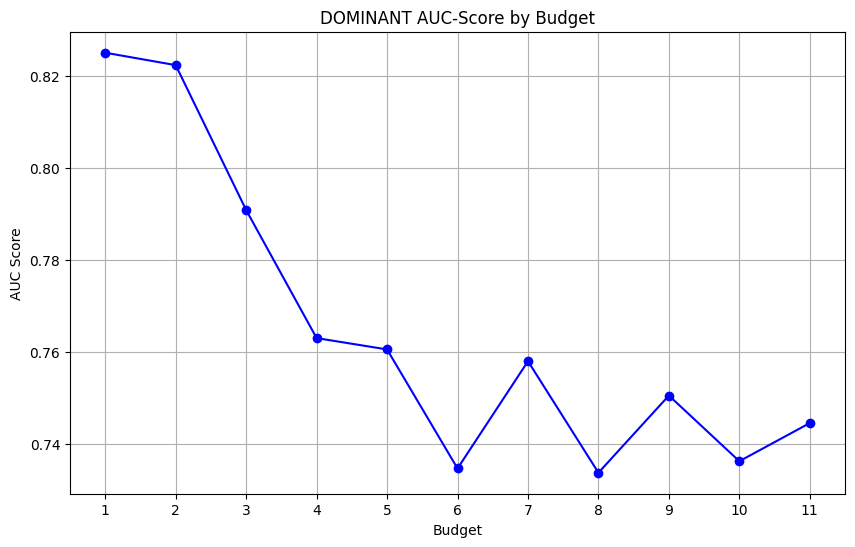

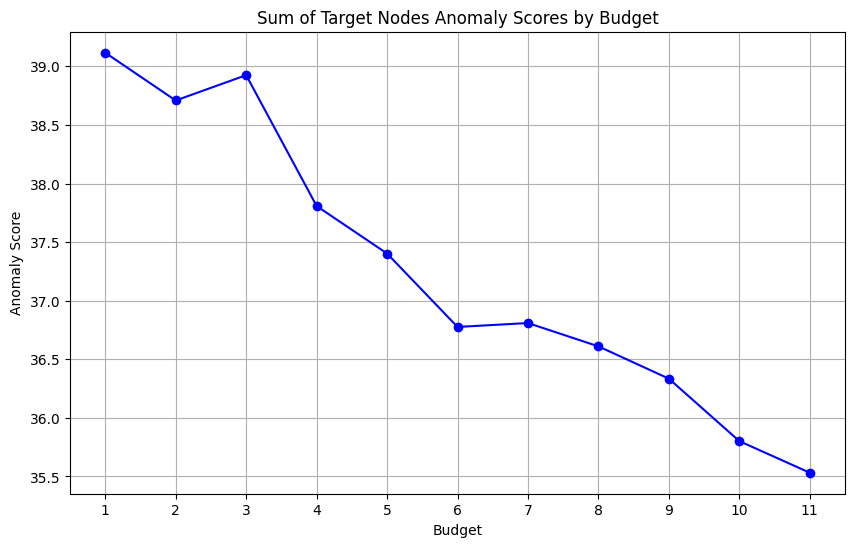

[39.116306, 38.70864, 38.92477, 37.807934, 37.402435, 36.77571, 36.809307, 36.61002, 36.334248, 35.80122, 35.53164]


In [8]:
import matplotlib.pyplot as plt

def plot_scores(scores, title='AUC Scores by Budget', xlabel='Budget', ylabel='AUC Score'):
    """
    Plots a list of scores against their corresponding budgets.

    Parameters:
    - scores: List of scores to plot.
    - title: Title of the plot.
    - xlabel: Label for the X-axis.
    - ylabel: Label for the Y-axis.
    """
    budgets = range(1, len(scores) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(budgets, scores, marker='o', linestyle='-', color='b')  # Plotting the scores

    # Adding some flair to the plot
    plt.title(title)  # Title of the plot
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.grid(True)  # Adding a grid for better readability

    # Set integer ticks on the X-axis
    plt.xticks(budgets)  # Set integer ticks

    # Display the plot
    plt.show()


plot_scores(AUC_DOM2, "DOMINANT AUC-Score by Budget")
plot_scores(AS_DOM2, "Sum of Target Nodes Anomaly Scores by Budget", "Budget", "Anomaly Score")
print(AS_DOM2)

In [9]:
def print_values_not_in_bigger_array(small_array, bigger_array):
    values_not_in_bigger_array = [value for value in small_array if value not in bigger_array]
    if values_not_in_bigger_array:
        print("Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies:", values_not_in_bigger_array)
    else:
        print("All values in the small array are present in the bigger array.")

target_list = np.array(testingModel.top_k_AS)
print_values_not_in_bigger_array(target_list, anomaly_list)

Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies: [1358, 1986, 1701, 306, 1810, 2034, 1013, 1072, 88, 1914, 733, 1169, 598, 109, 2045, 1725, 2155]


In [10]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

NameError: name 'CHANGE_IN_TARGET_NODE_AS' is not defined

Restarted PyGcuda (Python 3.9.19)

In [1]:
from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
from torch.optim import Optimizer
import torch
import sklearn
import numpy as np
import scipy.sparse as sp
from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any
import yaml
from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor
from gad_adversarial_robustness.poison.greedy import multiple_AS
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)

USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET = True
TOP_K = 20

data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()
print(y_binary)

anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
print(anomaly_list)


_, adj, _ = prepare_graph(data)


amount_of_nodes = data.num_nodes

# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges


print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)

tensor([False, False, False,  ..., False, False, False])
[  10   50   70   76  104  124  127  143  151  170  179  181  196  214
  217  224  227  287  289  294  311  333  425  438  451  454  459  539
  565  572  578  581  615  619  641  652  654  660  670  674  692  711
  722  738  781  833  843  869  874  878  882  891  895  915  923  938
  980  982  996 1002 1014 1035 1053 1079 1090 1096 1133 1135 1206 1211
 1224 1229 1235 1287 1293 1310 1362 1391 1414 1426 1533 1540 1543 1547
 1570 1573 1575 1606 1623 1633 1656 1674 1728 1730 1732 1783 1808 1818
 1833 1854 1881 1885 1901 1918 1946 1999 2004 2041 2052 2055 2056 2078
 2089 2121 2126 2198 2215 2234 2263 2265 2294 2307 2336 2340 2375 2382
 2386 2397 2475 2479 2506 2518 2551 2600 2624 2654 2658 2693]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,  

In [2]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')


if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])
sparse_adj = to_torch_sparse_tensor(edge_index)


print("Before poison:")
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False, top_k=TOP_K)

if USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET:
    print("TOP K_AS:")
    print(testingModel.top_k_AS) 
    target_list = np.array(testingModel.top_k_AS)
else:
    target_list = anomaly_list


print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 10

print("Starting attack...")
"""
# -------------
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------
"""

from gad_adversarial_robustness.gad.dominant.dominant_aggr import Dominant as Dominant2
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS2, AS_DOM2, AUC_DOM2, ACC_DOM2, perturb, edge_index, CHANGE_IN_TARGET_NODE_AS = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)

# -------------

Before poison:


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:64: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  src = src.to_sparse_csr()


Epoch: 0199, Auc: 0.8222494783736536
Top 20 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9803972244262695
Node ID: 1986, Anomaly Score: 2.6167619228363037
Node ID: 1701, Anomaly Score: 2.4650537967681885
Node ID: 306, Anomaly Score: 2.1993837356567383
Node ID: 1623, Anomaly Score: 2.140148162841797
Node ID: 1810, Anomaly Score: 2.1227774620056152
Node ID: 2034, Anomaly Score: 2.037991762161255
Node ID: 1013, Anomaly Score: 1.9535233974456787
Node ID: 88, Anomaly Score: 1.8888648748397827
Node ID: 1914, Anomaly Score: 1.8598908185958862
Node ID: 1072, Anomaly Score: 1.8598756790161133
Node ID: 733, Anomaly Score: 1.757734775543213
Node ID: 1169, Anomaly Score: 1.7559535503387451
Node ID: 598, Anomaly Score: 1.7504758834838867
Node ID: 1224, Anomaly Score: 1.7412382364273071
Node ID: 109, Anomaly Score: 1.7148338556289673
Node ID: 2045, Anomaly Score: 1.6972637176513672
Node ID: 1725, Anomaly Score: 1.644329309463501
Node ID: 2155, Anomaly Score: 1.5794893

c:\users\andwh\documents\p6\aau-dat6-poison-gad\gad_adversarial_robustness\poison\greedy.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3641.)
  E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T


106.85426250482264
[106.8542625]
After AS


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8233857779281566
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.105257987976074
Node ID: 1986, Anomaly Score: 2.6413779258728027
Node ID: 1701, Anomaly Score: 2.4735612869262695
Node ID: 306, Anomaly Score: 2.327692985534668
Node ID: 1623, Anomaly Score: 2.2076497077941895
Node ID: 1810, Anomaly Score: 2.128934144973755
Node ID: 2034, Anomaly Score: 2.046015739440918
Node ID: 1013, Anomaly Score: 1.9549976587295532
Node ID: 1072, Anomaly Score: 1.9033753871917725
Node ID: 88, Anomaly Score: 1.8777217864990234
initial anomaly score: 106.85426250482264
Perturbation number: 1


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8233688603169232
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.1575255393981934
Node ID: 1986, Anomaly Score: 2.5804357528686523
Node ID: 1701, Anomaly Score: 2.2953827381134033
Node ID: 306, Anomaly Score: 2.2243452072143555
Node ID: 1810, Anomaly Score: 2.112780809402466
Node ID: 1623, Anomaly Score: 2.07022762298584
Node ID: 2034, Anomaly Score: 1.9979147911071777
Node ID: 1013, Anomaly Score: 1.933663010597229
Node ID: 1072, Anomaly Score: 1.8611787557601929
Node ID: 88, Anomaly Score: 1.8282787799835205


ValueError: too many values to unpack (expected 3)

In [ ]:
import matplotlib.pyplot as plt

def plot_scores(scores, title='AUC Scores by Budget', xlabel='Budget', ylabel='AUC Score'):
    """
    Plots a list of scores against their corresponding budgets.

    Parameters:
    - scores: List of scores to plot.
    - title: Title of the plot.
    - xlabel: Label for the X-axis.
    - ylabel: Label for the Y-axis.
    """
    budgets = range(1, len(scores) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(budgets, scores, marker='o', linestyle='-', color='b')  # Plotting the scores

    # Adding some flair to the plot
    plt.title(title)  # Title of the plot
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.grid(True)  # Adding a grid for better readability

    # Set integer ticks on the X-axis
    plt.xticks(budgets)  # Set integer ticks

    # Display the plot
    plt.show()


plot_scores(AUC_DOM2, "DOMINANT AUC-Score by Budget")
plot_scores(AS_DOM2, "Sum of Target Nodes Anomaly Scores by Budget", "Budget", "Anomaly Score")
print(AS_DOM2)

: 

In [ ]:
def print_values_not_in_bigger_array(small_array, bigger_array):
    values_not_in_bigger_array = [value for value in small_array if value not in bigger_array]
    if values_not_in_bigger_array:
        print("Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies:", values_not_in_bigger_array)
    else:
        print("All values in the small array are present in the bigger array.")

target_list = np.array(testingModel.top_k_AS)
print_values_not_in_bigger_array(target_list, anomaly_list)

: 

In [ ]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

: 

Restarted PyGcuda (Python 3.9.19)

In [1]:
from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
from torch.optim import Optimizer
import torch
import sklearn
import numpy as np
import scipy.sparse as sp
from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any
import yaml
from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor
from gad_adversarial_robustness.poison.greedy import multiple_AS
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)

USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET = True
TOP_K = 20

data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()
print(y_binary)

anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
print(anomaly_list)


_, adj, _ = prepare_graph(data)


amount_of_nodes = data.num_nodes

# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges


print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)

tensor([False, False, False,  ..., False, False, False])
[  10   50   70   76  104  124  127  143  151  170  179  181  196  214
  217  224  227  287  289  294  311  333  425  438  451  454  459  539
  565  572  578  581  615  619  641  652  654  660  670  674  692  711
  722  738  781  833  843  869  874  878  882  891  895  915  923  938
  980  982  996 1002 1014 1035 1053 1079 1090 1096 1133 1135 1206 1211
 1224 1229 1235 1287 1293 1310 1362 1391 1414 1426 1533 1540 1543 1547
 1570 1573 1575 1606 1623 1633 1656 1674 1728 1730 1732 1783 1808 1818
 1833 1854 1881 1885 1901 1918 1946 1999 2004 2041 2052 2055 2056 2078
 2089 2121 2126 2198 2215 2234 2263 2265 2294 2307 2336 2340 2375 2382
 2386 2397 2475 2479 2506 2518 2551 2600 2624 2654 2658 2693]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,  

In [2]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')


if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])
sparse_adj = to_torch_sparse_tensor(edge_index)


print("Before poison:")
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False, top_k=TOP_K)

if USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET:
    print("TOP K_AS:")
    print(testingModel.top_k_AS) 
    target_list = np.array(testingModel.top_k_AS)
else:
    target_list = anomaly_list


print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 10

print("Starting attack...")
"""
# -------------
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------
"""

from gad_adversarial_robustness.gad.dominant.dominant_aggr import Dominant as Dominant2
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS2, AS_DOM2, AUC_DOM2, ACC_DOM2, perturb, edge_index, CHANGE_IN_TARGET_NODE_AS = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)

# -------------

Before poison:


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:64: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  src = src.to_sparse_csr()


Epoch: 0199, Auc: 0.8242908701291377
Top 20 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.0637125968933105
Node ID: 1986, Anomaly Score: 2.567913770675659
Node ID: 1701, Anomaly Score: 2.407071113586426
Node ID: 306, Anomaly Score: 2.17050838470459
Node ID: 1623, Anomaly Score: 2.150195360183716
Node ID: 1810, Anomaly Score: 2.122812032699585
Node ID: 2034, Anomaly Score: 2.0303194522857666
Node ID: 1013, Anomaly Score: 1.9583451747894287
Node ID: 88, Anomaly Score: 1.9169341325759888
Node ID: 1072, Anomaly Score: 1.8730254173278809
Node ID: 1914, Anomaly Score: 1.8359036445617676
Node ID: 598, Anomaly Score: 1.7602636814117432
Node ID: 1169, Anomaly Score: 1.7462379932403564
Node ID: 733, Anomaly Score: 1.7382934093475342
Node ID: 1224, Anomaly Score: 1.7219171524047852
Node ID: 109, Anomaly Score: 1.7128982543945312
Node ID: 2045, Anomaly Score: 1.6915664672851562
Node ID: 1725, Anomaly Score: 1.6576220989227295
Node ID: 2155, Anomaly Score: 1.586600303

c:\users\andwh\documents\p6\aau-dat6-poison-gad\gad_adversarial_robustness\poison\greedy.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3641.)
  E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T


106.69800586937129
[106.69800587]
After AS


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8220676140528957
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.224074363708496
Node ID: 1986, Anomaly Score: 2.658991813659668
Node ID: 1701, Anomaly Score: 2.608527421951294
Node ID: 306, Anomaly Score: 2.221022844314575
Node ID: 1623, Anomaly Score: 2.134214401245117
Node ID: 1810, Anomaly Score: 2.106694459915161
Node ID: 2034, Anomaly Score: 2.022531270980835
Node ID: 1013, Anomaly Score: 1.9545798301696777
Node ID: 1072, Anomaly Score: 1.902374505996704
Node ID: 88, Anomaly Score: 1.8896297216415405
initial anomaly score: 106.69800586937129
Perturbation number: 1


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8241668076467602
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.0405383110046387
Node ID: 1986, Anomaly Score: 2.609635829925537
Node ID: 306, Anomaly Score: 2.2807910442352295
Node ID: 1701, Anomaly Score: 2.2491273880004883
Node ID: 1623, Anomaly Score: 2.1485443115234375
Node ID: 1810, Anomaly Score: 2.1302385330200195
Node ID: 2034, Anomaly Score: 1.9748104810714722
Node ID: 1013, Anomaly Score: 1.9281742572784424
Node ID: 1072, Anomaly Score: 1.8793498277664185
Node ID: 88, Anomaly Score: 1.8191367387771606
Iteration: 1 --- Anomaly score: 105.91836983430731 --- DOM anomaly score: 38.87596 --- DOM AUC: 0.8241668076467602 --- TARGET DOM ACC: 0
Perturbation number: 2


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8075762702306436
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.1781136989593506
Node ID: 1986, Anomaly Score: 2.5989301204681396
Node ID: 306, Anomaly Score: 2.2156665325164795
Node ID: 1701, Anomaly Score: 2.205902099609375
Node ID: 1623, Anomaly Score: 2.121593713760376
Node ID: 1810, Anomaly Score: 2.1081948280334473
Node ID: 1013, Anomaly Score: 1.9428181648254395
Node ID: 1072, Anomaly Score: 1.901774287223816
Node ID: 2034, Anomaly Score: 1.8993180990219116
Node ID: 598, Anomaly Score: 1.7961127758026123
Iteration: 2 --- Anomaly score: 103.79139717925372 --- DOM anomaly score: 38.6857 --- DOM AUC: 0.8075762702306436 --- TARGET DOM ACC: 0
Perturbation number: 3


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7792364518130039
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.181081533432007
Node ID: 1986, Anomaly Score: 2.4220499992370605
Node ID: 306, Anomaly Score: 2.2166550159454346
Node ID: 1701, Anomaly Score: 2.1523799896240234
Node ID: 1623, Anomaly Score: 2.1440138816833496
Node ID: 1810, Anomaly Score: 2.004513740539551
Node ID: 1013, Anomaly Score: 1.9428939819335938
Node ID: 1072, Anomaly Score: 1.8772879838943481
Node ID: 2034, Anomaly Score: 1.8437366485595703
Node ID: 598, Anomaly Score: 1.795485019683838
Iteration: 3 --- Anomaly score: 103.10820767281146 --- DOM anomaly score: 37.941666 --- DOM AUC: 0.7792364518130039 --- TARGET DOM ACC: 0
Perturbation number: 4


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.757466305757627
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.044161558151245
Node ID: 1986, Anomaly Score: 2.3525450229644775
Node ID: 306, Anomaly Score: 2.162092685699463
Node ID: 1623, Anomaly Score: 2.11505126953125
Node ID: 1701, Anomaly Score: 2.0380122661590576
Node ID: 1013, Anomaly Score: 1.9358468055725098
Node ID: 1810, Anomaly Score: 1.8831453323364258
Node ID: 2034, Anomaly Score: 1.8593270778656006
Node ID: 1072, Anomaly Score: 1.8458507061004639
Node ID: 598, Anomaly Score: 1.7910641431808472
Iteration: 4 --- Anomaly score: 102.39809191256158 --- DOM anomaly score: 37.03449 --- DOM AUC: 0.757466305757627 --- TARGET DOM ACC: 0
Perturbation number: 5


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7413494614560424
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9844067096710205
Node ID: 1986, Anomaly Score: 2.2700655460357666
Node ID: 306, Anomaly Score: 2.229168653488159
Node ID: 1623, Anomaly Score: 2.147634744644165
Node ID: 1701, Anomaly Score: 2.0285778045654297
Node ID: 1013, Anomaly Score: 1.9327025413513184
Node ID: 2034, Anomaly Score: 1.8556034564971924
Node ID: 1072, Anomaly Score: 1.8538837432861328
Node ID: 598, Anomaly Score: 1.7990137338638306
Node ID: 1810, Anomaly Score: 1.7858036756515503
Iteration: 5 --- Anomaly score: 102.32140558336047 --- DOM anomaly score: 36.775127 --- DOM AUC: 0.7413494614560424 --- TARGET DOM ACC: 0
Perturbation number: 6


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7382930130265608
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.9262661933898926
Node ID: 1986, Anomaly Score: 2.235489845275879
Node ID: 306, Anomaly Score: 2.1900978088378906
Node ID: 1701, Anomaly Score: 2.0914952754974365
Node ID: 1623, Anomaly Score: 2.0573129653930664
Node ID: 1013, Anomaly Score: 1.9323879480361938
Node ID: 2034, Anomaly Score: 1.8684660196304321
Node ID: 1072, Anomaly Score: 1.8361668586730957
Node ID: 598, Anomaly Score: 1.807207703590393
Node ID: 1169, Anomaly Score: 1.7228420972824097
Iteration: 6 --- Anomaly score: 102.24459663581176 --- DOM anomaly score: 36.37476 --- DOM AUC: 0.7382930130265608 --- TARGET DOM ACC: 0
Perturbation number: 7


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7506118536062708
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.95613956451416
Node ID: 1986, Anomaly Score: 2.2164735794067383
Node ID: 306, Anomaly Score: 2.1331324577331543
Node ID: 1701, Anomaly Score: 2.1326889991760254
Node ID: 1623, Anomaly Score: 2.029630661010742
Node ID: 1013, Anomaly Score: 1.9430391788482666
Node ID: 1072, Anomaly Score: 1.841671347618103
Node ID: 598, Anomaly Score: 1.8015971183776855
Node ID: 2034, Anomaly Score: 1.8001947402954102
Node ID: 1810, Anomaly Score: 1.7283140420913696
Iteration: 7 --- Anomaly score: 101.65442026241563 --- DOM anomaly score: 36.430725 --- DOM AUC: 0.7506118536062708 --- TARGET DOM ACC: 0
Perturbation number: 8


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7410477640557154
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.991100311279297
Node ID: 306, Anomaly Score: 2.1490492820739746
Node ID: 1986, Anomaly Score: 2.1311631202697754
Node ID: 1623, Anomaly Score: 2.0474750995635986
Node ID: 1701, Anomaly Score: 2.0296154022216797
Node ID: 1013, Anomaly Score: 1.9427225589752197
Node ID: 1072, Anomaly Score: 1.8359315395355225
Node ID: 2034, Anomaly Score: 1.8126049041748047
Node ID: 598, Anomaly Score: 1.7980860471725464
Node ID: 1810, Anomaly Score: 1.7386865615844727
Iteration: 8 --- Anomaly score: 101.5851821840035 --- DOM anomaly score: 36.15941 --- DOM AUC: 0.7410477640557154 --- TARGET DOM ACC: 0
Perturbation number: 9


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7550217109344161
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.1088144779205322
Node ID: 1986, Anomaly Score: 2.1496834754943848
Node ID: 306, Anomaly Score: 2.123568296432495
Node ID: 1701, Anomaly Score: 2.008007049560547
Node ID: 1623, Anomaly Score: 1.9939589500427246
Node ID: 1013, Anomaly Score: 1.939198613166809
Node ID: 1072, Anomaly Score: 1.842687726020813
Node ID: 598, Anomaly Score: 1.79924738407135
Node ID: 109, Anomaly Score: 1.7064833641052246
Node ID: 2034, Anomaly Score: 1.705579161643982
Iteration: 9 --- Anomaly score: 101.5158305972791 --- DOM anomaly score: 36.049236 --- DOM AUC: 0.7550217109344161 --- TARGET DOM ACC: 0
Perturbation number: 10


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7371990075001409
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.8832216262817383
Node ID: 306, Anomaly Score: 2.066570281982422
Node ID: 1701, Anomaly Score: 2.024442195892334
Node ID: 1986, Anomaly Score: 2.016136407852173
Node ID: 1623, Anomaly Score: 2.0047736167907715
Node ID: 1013, Anomaly Score: 1.9327044486999512
Node ID: 1072, Anomaly Score: 1.8312404155731201
Node ID: 598, Anomaly Score: 1.8078967332839966
Node ID: 2034, Anomaly Score: 1.6992847919464111
Node ID: 1169, Anomaly Score: 1.6954905986785889
Iteration: 10 --- Anomaly score: 101.44636264026488 --- DOM anomaly score: 35.51309 --- DOM AUC: 0.7371990075001409 --- TARGET DOM ACC: 0


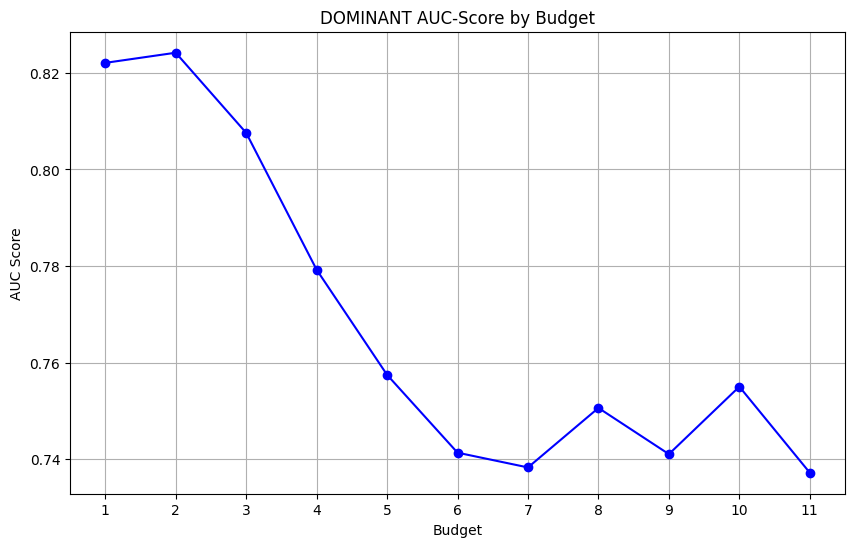

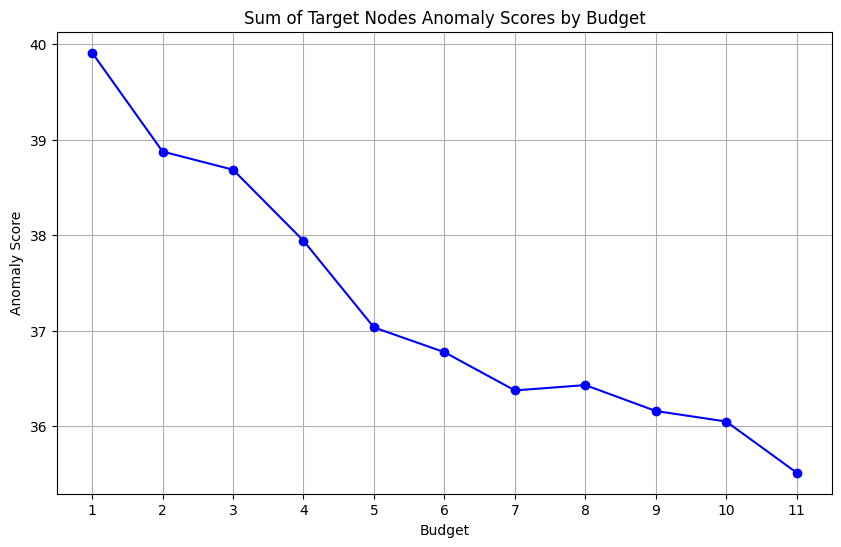

[39.910877, 38.87596, 38.6857, 37.941666, 37.03449, 36.775127, 36.37476, 36.430725, 36.15941, 36.049236, 35.51309]


In [3]:
import matplotlib.pyplot as plt

def plot_scores(scores, title='AUC Scores by Budget', xlabel='Budget', ylabel='AUC Score'):
    """
    Plots a list of scores against their corresponding budgets.

    Parameters:
    - scores: List of scores to plot.
    - title: Title of the plot.
    - xlabel: Label for the X-axis.
    - ylabel: Label for the Y-axis.
    """
    budgets = range(1, len(scores) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(budgets, scores, marker='o', linestyle='-', color='b')  # Plotting the scores

    # Adding some flair to the plot
    plt.title(title)  # Title of the plot
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.grid(True)  # Adding a grid for better readability

    # Set integer ticks on the X-axis
    plt.xticks(budgets)  # Set integer ticks

    # Display the plot
    plt.show()


plot_scores(AUC_DOM2, "DOMINANT AUC-Score by Budget")
plot_scores(AS_DOM2, "Sum of Target Nodes Anomaly Scores by Budget", "Budget", "Anomaly Score")
print(AS_DOM2)

In [4]:
def print_values_not_in_bigger_array(small_array, bigger_array):
    values_not_in_bigger_array = [value for value in small_array if value not in bigger_array]
    if values_not_in_bigger_array:
        print("Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies:", values_not_in_bigger_array)
    else:
        print("All values in the small array are present in the bigger array.")

target_list = np.array(testingModel.top_k_AS)
print_values_not_in_bigger_array(target_list, anomaly_list)

Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies: [1358, 1986, 1701, 306, 1810, 2034, 1013, 88, 1072, 1914, 598, 1169, 733, 109, 2045, 1725, 2155]


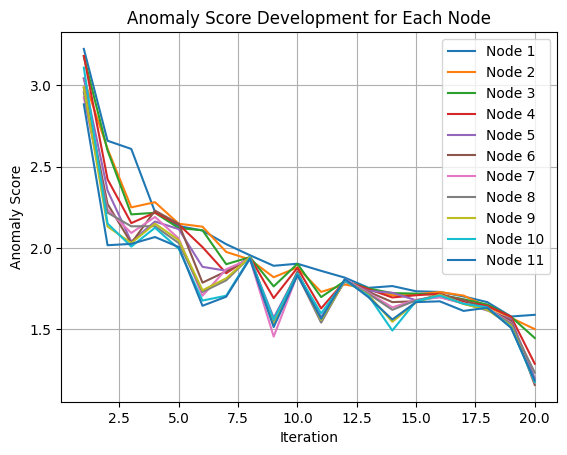

In [5]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

In [6]:
from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
from torch.optim import Optimizer
import torch
import sklearn
import numpy as np
import scipy.sparse as sp
from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any
import yaml
from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor
from gad_adversarial_robustness.poison.greedy import multiple_AS
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)

USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET = True
TOP_K = 20

data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()
print(y_binary)

anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
print(anomaly_list)


_, adj, _ = prepare_graph(data)


amount_of_nodes = data.num_nodes

# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges


print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)

tensor([False, False, False,  ..., False, False, False])
[  10   50   70   76  104  124  127  143  151  170  179  181  196  214
  217  224  227  287  289  294  311  333  425  438  451  454  459  539
  565  572  578  581  615  619  641  652  654  660  670  674  692  711
  722  738  781  833  843  869  874  878  882  891  895  915  923  938
  980  982  996 1002 1014 1035 1053 1079 1090 1096 1133 1135 1206 1211
 1224 1229 1235 1287 1293 1310 1362 1391 1414 1426 1533 1540 1543 1547
 1570 1573 1575 1606 1623 1633 1656 1674 1728 1730 1732 1783 1808 1818
 1833 1854 1881 1885 1901 1918 1946 1999 2004 2041 2052 2055 2056 2078
 2089 2121 2126 2198 2215 2234 2263 2265 2294 2307 2336 2340 2375 2382
 2386 2397 2475 2479 2506 2518 2551 2600 2624 2654 2658 2693]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,  

In [7]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')


if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])
sparse_adj = to_torch_sparse_tensor(edge_index)


print("Before poison:")
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False, top_k=TOP_K)

if USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET:
    print("TOP K_AS:")
    print(testingModel.top_k_AS) 
    target_list = np.array(testingModel.top_k_AS)
else:
    target_list = anomaly_list


print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 10

print("Starting attack...")
"""
# -------------
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------
"""

from gad_adversarial_robustness.gad.dominant.dominant_aggr import Dominant as Dominant2
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS2, AS_DOM2, AUC_DOM2, ACC_DOM2, perturb, edge_index, CHANGE_IN_TARGET_NODE_AS = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)

# -------------

Before poison:


c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8214740878587943
Top 20 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.99147629737854
Node ID: 1986, Anomaly Score: 2.6068549156188965
Node ID: 1701, Anomaly Score: 2.409693956375122
Node ID: 306, Anomaly Score: 2.1603758335113525
Node ID: 1623, Anomaly Score: 2.130000352859497
Node ID: 1810, Anomaly Score: 2.1204841136932373
Node ID: 2034, Anomaly Score: 1.9917614459991455
Node ID: 1013, Anomaly Score: 1.9606540203094482
Node ID: 1072, Anomaly Score: 1.8636808395385742
Node ID: 88, Anomaly Score: 1.8628438711166382
Node ID: 1914, Anomaly Score: 1.840559959411621
Node ID: 1169, Anomaly Score: 1.7611209154129028
Node ID: 598, Anomaly Score: 1.7512595653533936
Node ID: 1224, Anomaly Score: 1.7369662523269653
Node ID: 733, Anomaly Score: 1.7297148704528809
Node ID: 109, Anomaly Score: 1.7035526037216187
Node ID: 2045, Anomaly Score: 1.6882359981536865
Node ID: 1725, Anomaly Score: 1.6585028171539307
Node ID: 2155, Anomaly Score: 1.57584929

c:\Users\andwh\Anaconda3\envs\PyGcuda\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.822802120340608
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.966048240661621
Node ID: 1986, Anomaly Score: 2.582080841064453
Node ID: 1701, Anomaly Score: 2.3268282413482666
Node ID: 306, Anomaly Score: 2.16941499710083
Node ID: 1810, Anomaly Score: 2.127086877822876
Node ID: 1623, Anomaly Score: 2.1219096183776855
Node ID: 2034, Anomaly Score: 1.9929225444793701
Node ID: 1013, Anomaly Score: 1.9600389003753662
Node ID: 1072, Anomaly Score: 1.8799329996109009
Node ID: 88, Anomaly Score: 1.8417664766311646
initial anomaly score: 106.85426250482264
Perturbation number: 1


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_scores(scores, title='AUC Scores by Budget', xlabel='Budget', ylabel='AUC Score'):
    """
    Plots a list of scores against their corresponding budgets.

    Parameters:
    - scores: List of scores to plot.
    - title: Title of the plot.
    - xlabel: Label for the X-axis.
    - ylabel: Label for the Y-axis.
    """
    budgets = range(1, len(scores) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(budgets, scores, marker='o', linestyle='-', color='b')  # Plotting the scores

    # Adding some flair to the plot
    plt.title(title)  # Title of the plot
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.grid(True)  # Adding a grid for better readability

    # Set integer ticks on the X-axis
    plt.xticks(budgets)  # Set integer ticks

    # Display the plot
    plt.show()


plot_scores(AUC_DOM2, "DOMINANT AUC-Score by Budget")
plot_scores(AS_DOM2, "Sum of Target Nodes Anomaly Scores by Budget", "Budget", "Anomaly Score")
print(AS_DOM2)

: 

In [ ]:
def print_values_not_in_bigger_array(small_array, bigger_array):
    values_not_in_bigger_array = [value for value in small_array if value not in bigger_array]
    if values_not_in_bigger_array:
        print("Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies:", values_not_in_bigger_array)
    else:
        print("All values in the small array are present in the bigger array.")

target_list = np.array(testingModel.top_k_AS)
print_values_not_in_bigger_array(target_list, anomaly_list)

: 

In [ ]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

: 

In [ ]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Budget')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

: 

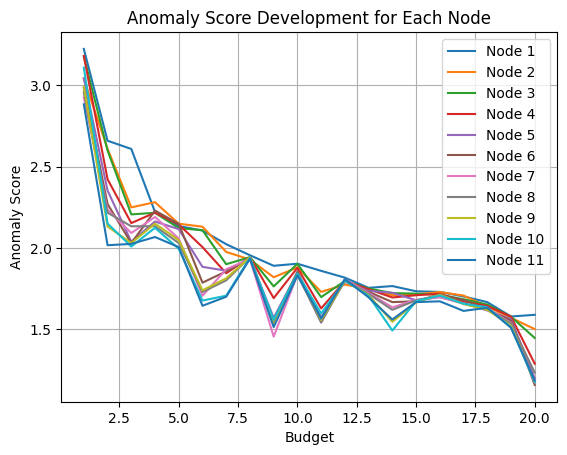

In [8]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Budget')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

ValueError: x and y must have same first dimension, but have shapes (20,) and (11,)

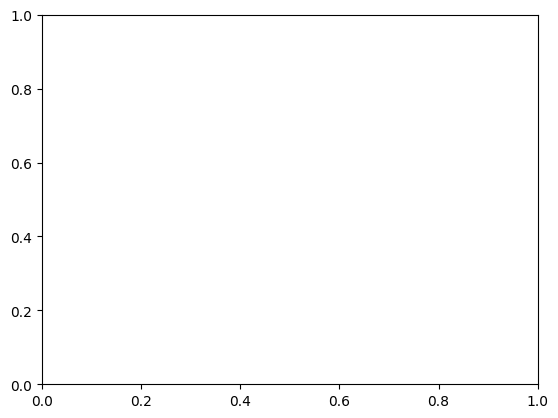

In [9]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(len(anomaly_scores[0]))

    for node_index in range(len(anomaly_scores[0])):
        scores = [iteration[node_index] for iteration in anomaly_scores]
        plt.plot(iterations, scores, label=f'Node {node_index + 1}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

ValueError: x and y must have same first dimension, but have shapes (20,) and (11,)

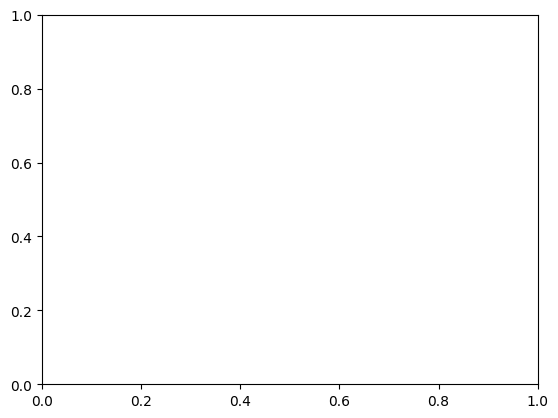

In [10]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(len(anomaly_scores[0]))

    for node_index in range(len(anomaly_scores[0])):
        scores = [iteration[node_index] for iteration in anomaly_scores]
        plt.plot(iterations, scores, label=f'Node {node_index + 1}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

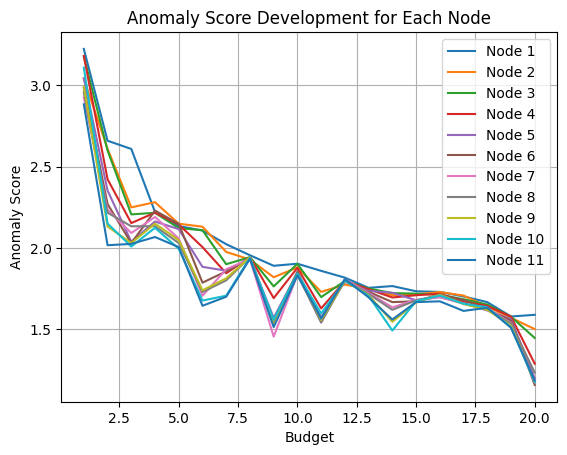

In [11]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Budget')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

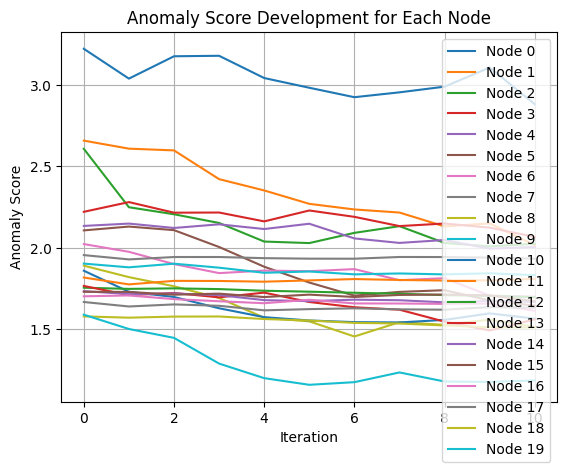

In [12]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Budget')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_anomaly_scores(anomaly_scores):
    iterations = range(len(anomaly_scores))  # Number of iterations

    for node_index in range(len(anomaly_scores[0])):
        node_scores = [scores[node_index] for scores in anomaly_scores]
        plt.plot(iterations, node_scores, label=f'Node {node_index}')

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


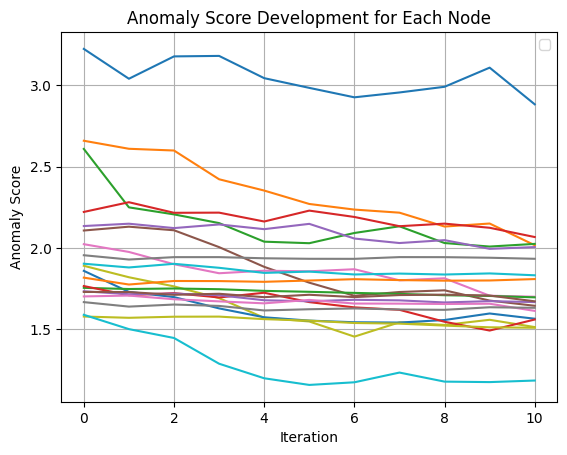

In [13]:
def plot_anomaly_scores(anomaly_scores):
    iterations = range(1, len(anomaly_scores[0]) + 1)

    for node_index, scores in enumerate(anomaly_scores, start=1):
        plt.plot(iterations, scores, label=f'Node {node_index}')

    plt.xlabel('Budget')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_anomaly_scores(anomaly_scores):
    iterations = range(len(anomaly_scores))  # Number of iterations

    for node_index in range(len(anomaly_scores[0])):
        node_scores = [scores[node_index] for scores in anomaly_scores]
        plt.plot(iterations, node_scores)

    plt.xlabel('Iteration')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Development for Each Node')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_anomaly_scores(CHANGE_IN_TARGET_NODE_AS)

In [14]:
def print_values_not_in_bigger_array(small_array, bigger_array):
    values_not_in_bigger_array = [value for value in small_array if value not in bigger_array]
    if values_not_in_bigger_array:
        print("Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies:", values_not_in_bigger_array)
    else:
        print("All values in the small array are present in the bigger array.")

target_list = np.array(testingModel.top_k_AS)
print_values_not_in_bigger_array(target_list, anomaly_list)

Indexes of nodes selected by topK AS by DOMINANT, that are not present in the list of injected anomalies: [1358, 1986, 1701, 306, 1810, 2034, 1013, 1072, 88, 1914, 1169, 598, 733, 109, 2045, 1725, 2155, 1042]


Connected to PyGcuda (Python 3.9.19)

In [1]:
from pygod.utils import load_data
